# Exploring the United States Election Datasets

This notebook demonstrates an intermediate approach to exploring and accessing the United States Election Datasets produced by the Library of Congress.

As an intermediate approach, this notebook uses functions as reusable blocks of code. These functions could potentially be used outside of this notebook to assist in further exploration.

# Imports
Below are the Python packages used in this notebook.

In [1]:
import requests # Used to make HTTP requests; this is how we will scrape the Wayback
from bs4 import BeautifulSoup # Used to process the scraped content 
import gzip # Used to decompress the gzipped CDX files
import pandas as pd # Used to transform the data into dataframes for computation
from sklearn.feature_extraction.text import CountVectorizer # Used to create a matrix out of a bag of words
from time import sleep # Used to provide a slight pause between Wayback requests

# Defining Global Variables
Here we’re defining two global variables that will be used in the functions to gather and scrape the content.
The represent the base of the URL structure for two of the important web applications we will use: Cloudfront, which is the front end to where the dataset files are location and Wayback, where the actual web resources are accessed.

In [2]:
CLOUDFRONT_BASE_URL = 'https://d2rxokvmqqcpq7.cloudfront.net/'
WAYBACK_BASE_URL = 'https://webarchive.loc.gov/all/'

# Functions
Here we will define the functions in the order that they are used in this notebook. 

In [3]:
def gather_files_from_manifest(year: str):
    """
    Function that takes a year (YYYY) as an argument.
    The function collects the locations of the CDX files 
    listed by the provided year's manifest.
    
    Args:
        year (str): String of a year YYYY.

    Returns:
        :obj:`list` of :obj:`str` of individual CDX file URLs.
    """
    
    election_years = [
        "2000",
        "2002",
        "2004",
        "2006",
        "2008",
        "2010",
        "2012",
        "2014",
        "2016",
        "2018"
    ]
    
    if year not in election_years:
        return []
    else:
        manifest_url = f"{CLOUDFRONT_BASE_URL}cdx11-indexes/{year}/el{year[-2:]}-manifest.html"
        response = requests.get(manifest_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        cdx_files = [link.get('href') for link in soup.find_all('a')]

        return cdx_files

def fetch_file(cdx_url: str):
    """
    Function that takes a `String` as an argument.
    The `cdx_url` is a singular item from the result
    of the `gather_files_from_manifest` function.
    The function fetches the gzipped CDX file, decompresses it,
    splits it on the newlines, and removes the header. 
    Args:
        cdx_url (str): Individual item from the result of
        the `gather_files_from_manifest` function.

    Returns:
        :obj:`list` of :obj:`str` of individual CDX lines, each representing
        a web object.
    """
    response = requests.get(cdx_url)
    
    # Here we decompress the gzipped CDX, decode it, split it on the newline, and remove the header
    cdx_content = gzip.decompress(response.content).decode('utf-8').split('\n')[1:]
        
    return cdx_content

def create_dataframe(data: list):
    """
    Function that takes a :obj:`list` of :obj:`str` as an argument.
    `data` is the contents of the CDX file split on newlines. 
    This function takes `data`, applies a schema to it, and transforms it
    into a `pandas.DataFrame`.
    Args:
        data (list): :obj:`list` of :obj:`str`. Each item is a line from
        a CDX file or group of files.

    Returns:
        A `pandas.DataFrame` of a CDX file or group of files.
    """
    schema = [
        'urlkey',
        'timestamp',
        'original',
        'mimetype',
        'statuscode',
        'digest',
        'redirect',
        'metatags',
        'file_size',
        'offset',
        'warc_filename'
    ]
    _data = [row.split() for row in data]
    
    df = pd.DataFrame(_data, columns=schema)
    
    return df

def create_dataframe_from_manifest(manifest: list):
    """
    Function that takes a :obj:`list` of :obj:`str` as an argument.
    The `manifest` is a list of all the individual CDX files found
    from an Election year's or group of Election years' HTML manifest.
    This function loops through each file, transforms it into a `pandas.DataFrame`
    by calling the `create_dataframe` function, concats the DataFrames together,
    and then returns the Dataframe representing the entire manifest.
    Args:
        manifest (list): :obj:`list` of :obj:`str` of all the individual CDX files found
    from an Election year's or group of Election years' HTML manifest.

    Returns:
        `pandas.DataFrame` representing every file present in the `manifest`.
    """
    df = pd.DataFrame() 
    for index, line in enumerate(manifest[0:2]):
        cdx = fetch_file(line)
        if index == 0:
            df = create_dataframe(cdx)
        else:
            df = pd.concat([df, create_dataframe(cdx)])
    return df

def fetch_text(row: pd.Series):
    """
    Function that takes a `pandas.Series`, which is a single row 
    from a `pandas.DataFrame`, as an argument.
    The functions uses the timestamp and original fields from the `row`
    to request the specific resource. Once the resource is fetched,
    the Wayback banner div elements are removed so as to not detract from 
    the words in the resource itself. 
    Args:
        row (pandas.Series): `pandas.Series`, which is a single row 
    from a `pandas.DataFrame`.

    Returns:
        `String` of the resource's text.
    """
    response = requests.get(f"{WAYBACK_BASE_URL}{row['timestamp']}/{row['original']}")
    soup = BeautifulSoup(response.content, 'html.parser')
    [el.extract() for el in soup.find_all('div', {'id': 'wm-maximized'})]
    [el.extract() for el in soup.find_all('div', {'id': 'wm-minimized'})]
    return soup.text

def fetch_all_text(df: pd.DataFrame):
    """
    Function that takes a `pandas.Dataframe` as an argument.
    This is the most complicated function here. The function first cleans the
    `df` that was passed in by dropping all the rows that do not have a value in the
    mimetype field. Then, it drops all the duplicate digests, which removes resources
    that are exactly the same. Finally, it only returns rows that have 'text' in the mimetype
    and have a '200' HTTP status response, meaning the resource was sucessfully capture.
    Once the `df` is cleaned, each resource's text is fetched from the Wayback,
    transformed into a matrix using `sklearn.CountVectorizer`, and then returns a `pandas.DataFrame`
    with words and their occurance per resource. A politeness of 15 seconds is added between Wayback requests.
    Args:
        row (pandas.DataFrame): `pandas.Dataframe` representing web resources as CDX lines.

    Returns:
        `pandas.Dataframe` of the resource's words tabulated per web resource.
    """
    countvec = CountVectorizer(ngram_range=(1,1), stop_words='english')
    unprocessed_bag_of_words = []
    text_df = df\
        .dropna(subset=['mimetype'])\
        .drop_duplicates(subset=['digest'])\
        .query('mimetype.str.contains("text") and statuscode.str.match("200")', engine='python')
    
    for i, row in text_df.iterrows():
        unprocessed_bag_of_words.append(fetch_text(row))
        sleep(15)
    
    processed_bag_of_words = countvec.fit_transform(unprocessed_bag_of_words)
    
    return pd.DataFrame(processed_bag_of_words.toarray(),columns=countvec.get_feature_names())

### Gathering the list of CDX Files

The first step is gathering the list of CDX files. To do that, simply call the `gather_files_from_manifest` function, providing the Election year as an argument.

In [4]:
el00_files = gather_files_from_manifest('2000')

In [5]:
el00_files[:5]

['https://d2rxokvmqqcpq7.cloudfront.net/cdx11-indexes/2000/unique.20010415093936.surt.cdx.gz',
 'https://d2rxokvmqqcpq7.cloudfront.net/cdx11-indexes/2000/unique.20010415094743.surt.cdx.gz',
 'https://d2rxokvmqqcpq7.cloudfront.net/cdx11-indexes/2000/unique.20010415095044.surt.cdx.gz',
 'https://d2rxokvmqqcpq7.cloudfront.net/cdx11-indexes/2000/unique.20010415095244.surt.cdx.gz',
 'https://d2rxokvmqqcpq7.cloudfront.net/cdx11-indexes/2000/unique.20010415095459.surt.cdx.gz']

### CDX File
Next, we'll demonstrate what a particular CDX File looks like

In [6]:
cdx = fetch_file(el00_files[0])

In [7]:
cdx[:5]

['com,voter)/home/candidates/info/0,1214,2-11880-,00.html 20001002182124 http://www.voter.com:80/home/candidates/info/0,1214,2-11880-,00.html text/html 200 FYXP43MQC5GVBQMVK3ETWSPXUBR5ICKP - - 5051 149 unique.20010415093936.arc.gz',
 'com,voter)/home/candidates/info/0,1214,2-18885-,00.html 20001002185814 http://www.voter.com:80/home/candidates/info/0,1214,2-18885-,00.html text/html 200 H6QN5ZULJ6YZP756QNVM3YXKXC7HZUIL - - 4829 5200 unique.20010415093936.arc.gz',
 'com,voter)/home/candidates/info/0,1214,2-18880-,00.html 20001002185815 http://www.voter.com:80/home/candidates/info/0,1214,2-18880-,00.html text/html 200 HFG67JI4KBPHFXMQE5DJRHF3OEKKBOO6 - - 4794 10029 unique.20010415093936.arc.gz',
 'com,voter)/home/officials/general/1,1195,2-2467-,00.html 20001002185815 http://voter.com:80/home/officials/general/1,1195,2-2467-,00.html text/html 200 HZJFLTHZD5MGEPJS2WVGBHQRQUPFBE3O - - 5282 14823 unique.20010415093936.arc.gz',
 'com,voter)/home/candidates/info/0,1214,2-18886-,00.html 2000100

### CDX as a DataFrame
Now, here is the same CDX transformed into a DataFrame

In [8]:
cdx_df = create_dataframe(cdx)

In [9]:
cdx_df

,urlkey,timestamp,original,mimetype,statuscode,digest,redirect,metatags,file_size,offset,warc_filename
0,"com,voter)/home/candidates/info/0,1214,2-11880...",20001002182124,http://www.voter.com:80/home/candidates/info/0...,text/html,200,FYXP43MQC5GVBQMVK3ETWSPXUBR5ICKP,-,-,5051,149,unique.20010415093936.arc.gz
1,"com,voter)/home/candidates/info/0,1214,2-18885...",20001002185814,http://www.voter.com:80/home/candidates/info/0...,text/html,200,H6QN5ZULJ6YZP756QNVM3YXKXC7HZUIL,-,-,4829,5200,unique.20010415093936.arc.gz
2,"com,voter)/home/candidates/info/0,1214,2-18880...",20001002185815,http://www.voter.com:80/home/candidates/info/0...,text/html,200,HFG67JI4KBPHFXMQE5DJRHF3OEKKBOO6,-,-,4794,10029,unique.20010415093936.arc.gz
3,"com,voter)/home/officials/general/1,1195,2-246...",20001002185815,"http://voter.com:80/home/officials/general/1,1...",text/html,200,HZJFLTHZD5MGEPJS2WVGBHQRQUPFBE3O,-,-,5282,14823,unique.20010415093936.arc.gz
4,"com,voter)/home/candidates/info/0,1214,2-18886...",20001002185816,http://www.voter.com:80/home/candidates/info/0...,text/html,200,QAM7JW7S4CNYMP6HLA6DASOXTO2SIGWO,-,-,4823,20105,unique.20010415093936.arc.gz
...,...,...,...,...,...,...,...,...,...,...,...
1096875,"com,voter)/home/candidates/info/0,1214,2-9118-...",20001002183052,http://www.voter.com:80/home/candidates/info/0...,-,-,3I42H3S6NNFQ2MSVX7XZKYAYSCX5QBYJ,-,-,118,145323588,unique.20010415093936.arc.gz
1096876,"com,voter)/home/candidates/info/0,1214,2-9115-...",20001002183052,http://www.voter.com:80/home/candidates/info/0...,-,-,3I42H3S6NNFQ2MSVX7XZKYAYSCX5QBYJ,-,-,118,145323706,unique.20010415093936.arc.gz
1096877,"com,voter)/home/candidates/info/0,1214,2-15361...",20001002182249,http://www.voter.com:80/home/candidates/info/0...,-,-,3I42H3S6NNFQ2MSVX7XZKYAYSCX5QBYJ,-,-,119,145323824,unique.20010415093936.arc.gz
1096878,"com,voter)/home/candidates/info/0,1214,2-12994...",20001002181842,http://www.voter.com:80/home/candidates/info/0...,text/html,404,UDSH36NBYWO2X73LNMX2LEHLNQ7FYXHZ,-,-,351,145323943,unique.20010415093936.arc.gz


### Election 2000 DataFrame
Now we'll just create a DataFrame from the whole 2000 Election dataset. To do that, we'll use the `create_dataframe_from_manifest` which loops over the files and calls `create_dataframe` programmatically instead of manually and individually as we did above. 

In [10]:
el00_df = create_dataframe_from_manifest(el00_files)

### Mimetypes
For this exercise, we're going to take a brief look at the mimetypes. First, we'll select all the mimetypes in the Dataframe and get their sums by calling `value_counts` which is a method from Pandas. 

In [11]:
el00_mimetypes = el00_df['mimetype'].value_counts()

In [12]:
el00_mimetypes

-                           1094810
text/html                      6209
application/pdf                  13
image/gif                        11
image/jpeg                        4
text/plain                        3
application/mac-binhex40          1
Name: mimetype, dtype: int64

### Dropping and Graphing
You can see from the output above, that the majority of the mimetypes are not listed and show up as `-`. Further research into this could prove interesting. For now, however, we're just going to drop them and graph the remainder.

<AxesSubplot:>

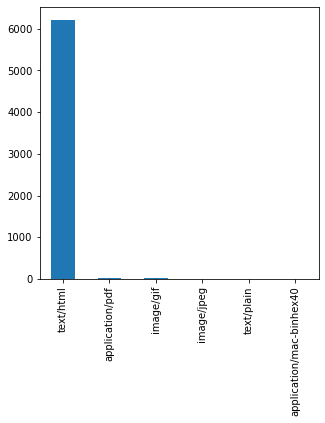

In [13]:
el00_mimetypes.drop(labels=['-']).plot.bar(figsize=(5,5))

### Fetching the Text
Now that we know the majority of the remaining resources in this dataset have a text-based mimetype, we can gather all the text and do some basic analysis. First, we'll fetch all the text from just the first 50 rows. If you have access to a larger machine, you may certainly increase the number or run it across the whole DataFrame.

In [14]:
text_df = fetch_all_text(el00_df.head(50))

### Top 25 Words
Now that the text has been fetched, we'll do a simple summation and sorting, displaying the top 25 words from the first 50 rows of the 2000 Election dataset.

In [15]:
text_df.sum(axis=0).sort_values(ascending=False).head(25)

information    248
com            150
voter          150
terms          121
contact        119
state          105
candidate       95
service         78
return          72
senate          70
candidates      62
elected         62
officials       62
check           56
ca              54
new             53
capitol         52
background      52
general         51
use             51
rights          50
press           50
2000            50
privacy         50
portions        50
dtype: int64

## Next Steps
Please feel free to use this notebook and the functions found here to help in your exploration of the U.S. Election datasets.